In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from icecream import ic

from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

## Time delay spectral fit with SciPy, time resolution and FWHM (full width at half maximum)

FWHM can be calculated either by reading the two points of the gaussian curve at half maximum, or by using the standard deviation, see [https://de.wikipedia.org/wiki/Halbwertsbreite]

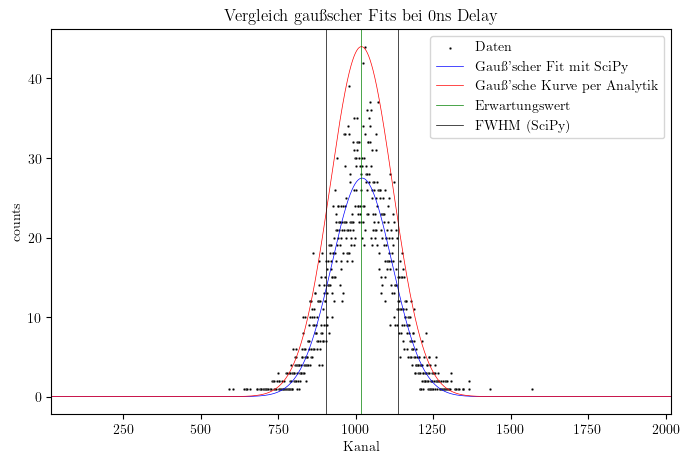

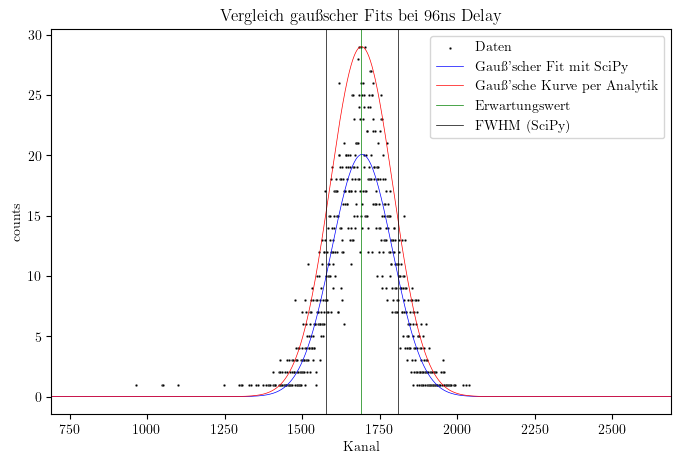

ic| peakdifference: 672.7503678471718


mean:   [1020.5469567242234, 1693.2973245713952] ± [0.3654007077490951, 0.3949611617448779]
std:    [97.62584292360974, 98.1100078261279] ± [0.36540070810730435, 0.39496116072524473]
FWHM of 0ns and 96ns (numerical curve reading):   [229.8941825571244, 231.03233965011714]
FWHM of 0ns and 96ns (using fitted sigma):        [229.89129182955907, 231.03141304710928]


In [5]:
def gaussian(x,y,mean,sigma): 
    return y * np.exp(-(x-mean)**2 / (2*sigma**2) )

peak=[]
peakerror=[]
std=[]
stderror=[]
fwhmlist=[] # curve reading from np.interp
fwhm2list = [] # computation from 2 sqrt(2ln2) sigma. Note: use the correct sigma from scipy (third entry of popt), not the analytical one
x_list=[]
def timedelayplot(data, title):
    # this function is actually not good, as it computes the mean, computes the gaussian and plots the function all in one. This reduces flexibility. 
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'Kanal'

    # computing gaussian parameters mu and sigma, required for both analytical and numerical fit
    y = df['counts']
    x = df.index
    mean = sum(y * x) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y) )
    # ic(mean, sigma)
    # peak.append(mean)
    # std.append(sigma) # -> wrong sigma to be used, as this is the analytical sigma

    # performing a gaussian fit
    popt,pcov = curve_fit(gaussian,x,y,p0=[max(y),mean,sigma])
    peak.append(popt[1])
    std.append(popt[2])

    # fwhm by reading the curve with np.interp
    t_asc = np.linspace(0,mean,1000)
    t_desc = np.linspace(mean,2400,1000)
    y_half = gaussian(x,*popt).max() / 2
    # ic(y_half)
    x_asc = np.interp(y_half, gaussian(t_asc,*popt), t_asc)
    # ic(x_asc)
    # ic(gaussian(x_asc, *popt))
    x_desc = np.interp(y_half, gaussian(t_desc,*popt)[::-1], t_desc[::-1])
    # ic(x_desc)
    # ic(gaussian(x_desc, *popt))
    fwhm = x_desc - x_asc
    # ic(fwhm)
    fwhmlist.append(fwhm)
    x_list.append(x_asc)
    x_list.append(x_desc)

    # fwhm2 with fitted sigma
    fwhm2 = 2 * np.sqrt(2 * np.log(2)) * popt[2]
    # ic(fwhm2)
    fwhm2list.append(fwhm2)
    

    # error 
    # ic(popt)
    error = np.sqrt(np.diag(pcov))
    # ic(error)
    peakerror.append(error[1])
    stderror.append(error[2])
    # ic(error)
    
    # plot
    fig, ax = plt.subplots(figsize=(8,5))
    df['counts'] = df.loc[df['counts'] > 0]
    sns.scatterplot(x=df.index, y=df['counts'], s=3, color='k', label='Daten')
    ax.plot(x, gaussian(x,*popt), 'b-', linewidth=.5, label=f'Gauß\'scher Fit mit SciPy')
    ax.plot(x, gaussian(x,y=df['counts'].max(),mean=mean,sigma=sigma), color='r', linewidth=.5, label='Gauß\'sche Kurve per Analytik')
    ax.axvline(mean, linewidth=.5, color='g', label='Erwartungswert')
    ax.axvline(x_asc, linewidth=.5, color='k', label='FWHM (SciPy)')
    ax.axvline(x_desc, linewidth=.5, color='k')
    ax.set_title(title)
    ax.set_xlim(mean-1000, mean+1000) 
    ax.legend()
    plt.savefig(f"plots/{title}.pdf")
    plt.show()


timedelayplot('Results/zeitspektrum_0nsdelay.asc','Vergleich gaußscher Fits bei 0ns Delay')
timedelayplot('Results/zeitspektrum_96nsdelay.asc','Vergleich gaußscher Fits bei 96ns Delay')

peakdifference = peak[1]-peak[0]
ic(peakdifference)
# print()

print("mean:  ", peak, f"\u00B1",peakerror)
print("std:   ", std, f"\u00B1", stderror)

print("FWHM of 0ns and 96ns (numerical curve reading):  ", fwhmlist)
print("FWHM of 0ns and 96ns (using fitted sigma):       ", fwhm2list)

- The manual curve (red) includes the maximal peak value $\textbf{at the cost of overestimating the overall count rate}$. Notice how most data points are under the curve.
- The fitted curve (blue) takes the variation of the count rate into account. Notice how the curve goes through the middle of the "width" of the data. It doesn't reach the maximal count value, but this is due to the large variation of count value at the mean channel value. \
Conclusion: the fitted plot is the more reliable one. 

\begin{align}
    \Delta_{\text{difference}} t &= b \cdot \Delta_{\text{difference}} K
\end{align}
And we use the standard deviation as an initial point for the error propagation:
\begin{align}
    \Delta b &= \frac{\Delta t}{(\Delta K)^2} \Delta(\Delta K) \\
    \Delta (\Delta_d K)   &= \sqrt{ \sum_{i} \left( \frac{\partial (\Delta_d K)}{\partial \mu_i} \sigma_i \right)^2} \\
                        &= \sqrt{ \sigma_1^2 + \sigma_2^2 } \\
    \Delta T &= \sqrt{ (K_i*\Delta b)^2 + (b * \sigma_i) }
\end{align}

ic| b: 0.14269780380381486
ic| delta_K: 138.40657080568175
ic| delta_b: 0.02935756653569701
ic| [b,delta_b]: [0.14269780380381486, 0.02935756653569701]
ic| std: [97.62584292360974, 98.1100078261279]
ic| [t0, delta_t0]: [0, 13.930993379695309]
ic| [t96, delta_t96]: [13.698989165166227, 14.28094106758643]
ic| x_list: [905.6000302933694, 1135.4942128504938, 1577.781223836034, 1808.8135634861512]
ic| fwhmlist: [229.8941825571244, 231.03233965011714]
ic| [delta_fwhm0, delta_fwhm96]: [6.749133760590454, 6.782547283176064]


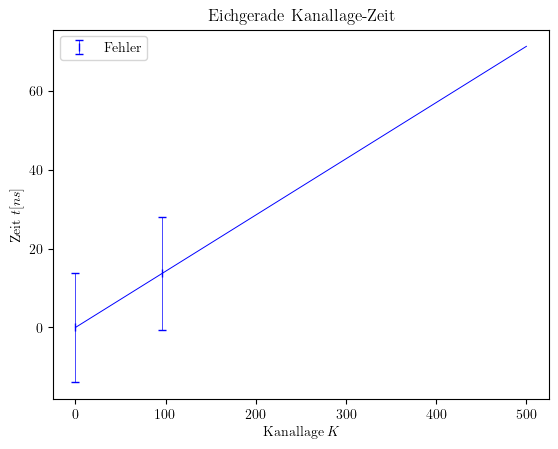

In [3]:
b = 96 / peakdifference
ic(b)
delta_K = np.sqrt( std[0]**2 + std[1]**2 )
ic(delta_K)
delta_b = (96 * delta_K) / (peakdifference)**2
ic(delta_b)
ic([b,delta_b])
ic(std)

t0 = 0
delta_t0 = b * std[0]
ic([t0, delta_t0])
t96 = b * 96
delta_t96 = np.sqrt( (96 * delta_b)**2 + (b * std[1])**2 )
ic([t96, delta_t96])

x_error_points = [0, 96]
y_error_points = [0, t96]
y_errors = [delta_t0, delta_t96]

ic(x_list)
delta_fwhm0 = np.sqrt( (x_list[1] - x_list[0])**2 * delta_b**2  )
delta_fwhm96 = np.sqrt( (x_list[3] - x_list[2])**2 * delta_b**2  )
ic(fwhmlist)
ic([delta_fwhm0, delta_fwhm96])

def calibratetime(ch):
    return np.float64(ch) * np.float64(b)

ch = np.linspace(0,500,1000)
fig, ax = plt.subplots()
ax.plot(ch, calibratetime(ch), 'b', linewidth=.7)
ax.errorbar(x_error_points, y_error_points, yerr=y_errors, fmt='|', capsize=3, color='b',linewidth=.5, label='Fehler')
ax.set_title('Eichgerade Kanallage-Zeit')
ax.set(xlabel=f'Kanallage $K$', ylabel=f'Zeit $t [ns]$ ')
ax.legend()
plt.savefig("plots/Eichgerade Zeit.pdf")
plt.show()

In [4]:
calibratedfwhm = []
ic(fwhmlist)
for k in fwhmlist:
    calibratedfwhm.append(calibratetime(k))

ic(calibratedfwhm)
ic([delta_fwhm0, delta_fwhm96])
print("FWHM (calibrated, in unit ns):   ", calibratedfwhm)

ic| fwhmlist: [229.8941825571244, 231.03233965011714]
ic| calibratedfwhm: [32.80539495817494, 32.96780747572873]
ic| [delta_fwhm0, delta_fwhm96]: [6.749133760590454, 6.782547283176064]


FWHM (calibrated, in unit ns):    [32.80539495817494, 32.96780747572873]
